## MSc Data Analytics

### Integrated CA 1 - Semester 2 
### Clarissa Cardoso - 2020274


## Advanced Data Analytics Big Data Storage and Processing


### Spotify Top 200 songs Ireland - Deep Learning using Big Data for predicting song ranking

The goal of this project is to develop a deep learning algorithm using big data tools (in this case pyspark libraries) to predict song popularity in Ireland. 


This Notebook is divided in smaller sections as follows:
- 1. Introduction

- 2.Data Preparation and EDA: Gather historical data on the top 200 songs in Ireland from Spotify. Clean, transform, and prepare the data for training the predictive model.

- 3.Feature Engineering: Identify and select relevant features such as song attributes, historical rankings, and number of streams to understand how they influence song popularity.

- 4.Model Development: Utilize deep learning techniques, employing Recurrent Neural Networks (RNNs) or Long Short-Term Memory networks (LSTMs), to build a predictive model for song ranking.

- 5.Training and Validation: Train the model on historical data, validating its performance against known outcomes to ensure accuracy and reliability. Changing necessary parameters when needed.

- 6.Forecasting: Employ the trained model to predict the top 10 songs in Ireland's weekly charts for upcoming weeks, providing valuable insights for the persons involved.


 
 >Challenges:
Temporal Dynamics: Account for evolving musical trends and preferences, ensuring the model remains adaptable over time. 
Data Quality Assurance: Ensure the collected data is accurate, complete, and representative of the Irish music landscape.
Model Fine-Tuning: Continuously refine and improve the model to enhance its predictive capabilities and adaptability to changing trends."


## 1. Introduction



Original dataset obtained in kaggle (available at: https://www.kaggle.com/datasets/dhruvildave/spotify-charts) and containg the historical data of the TOP200 charts for 69 countries plus Global trends, collected between <b> 01-01-2017 to 31-12-2021.</b> 
In order to optmize storage space within the virtual machine created to develop hadoop and pyspark tools, a sample dataset was created based on the original, where only the Irish rankings were selected and stored on a new csv file (of 56MB) used in this Notebook, considering the size of original csv file is over 3GB and considering the time resources and technical knowledge limitations are present to develop this project, this was the solution found to carry on. 







In [62]:
# importing necessary libraries to deploy pyspark functions

from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

from pyspark.sql.functions import count # Funcion to get the "size" of the data.
from pyspark.sql.functions import when # When function.
from pyspark.sql.functions import col # Function column.
from pyspark.sql.functions import mean, min, max, stddev # Imports function for statistical features. 
from pyspark.sql import functions as F # Data processing framework.
from pyspark.sql.functions import lower # lower case function.
from pyspark.sql.functions import length # Import lenght function.
from pyspark.sql.functions import size, split # Imports function size and split.
from pyspark.ml.feature import Tokenizer # Importing Tokenizer.
from pyspark.sql.functions import regexp_replace # Remove / Replace function.
from pyspark.sql.types import StructField, StructType # Importing features for Schema.
from pyspark.sql.types import IntegerType, StringType, TimestampType # Tools to create the schema.
from pyspark.sql.functions import udf # Imports function UDF (user defined functions).
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import max as max_


import numpy as np # for numerical operations.
import pandas as pd #dataframe manipulation
import seaborn as sns # basic visualization
from scipy import stats
import matplotlib.pyplot as plt # visualization
%matplotlib inline 

import re # for extracting special characters


import warnings # Ignore warnings.
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split # importing function to split the data training and test.
from sklearn.preprocessing import MinMaxScaler # Import the MinMaxScaler module from sklearn.preprocessing library
from sklearn.linear_model import LinearRegression # importing to performe linear regression. 
from sklearn.metrics import make_scorer, r2_score # Importing from Metrics module
from sklearn.preprocessing import StandardScaler # standardize the data
from sklearn import metrics # Metrics module from scikit-learn
from sklearn.model_selection import GridSearchCV # importing for hyperparameter tunning
from sklearn.metrics import mean_squared_error # importing mse

## 1. Data Preparation and EDA

The original dataset retrieved from Kaggel via the link specified above is over 3GB in size. As a solution to not overuse the limited space in the VM, outside of the vm a separate Jupyter notebook was created to filter the data needed for this project, as a sample containing Ireland data from 2017 to 2021. The original csv file contains a mix of two trends collected: "Top200 chart" and "Viral 50" across 26,173,514 observations in 9 columns containg attributes such as song title, position in rank, date collectes, artist, region, type of chart present and streams.  Once the sample was completed the new shape for charts_irl is of 449,311 rows, still a significant size across the same 9 columns:

- title: title of each song
- rank: position in daily rankings
- date: dates which the chart was published
- artist: name of artist
- url: spotify url directing to each song 
- region: country (filtered for: 'Ireland')
- chart: top200 chart or viral 50, Spotify's own charts to measure popular songs 
- trend: evolution of songs position in daily ranks, if moved up or down, new entry or if remains a neutral position
- streams: number of streams 


Though, an early EDA made possible to see the trend of viral 50 do not posses the total streams count for each song as pointed in the data source. This is why the data cleaning for this project aims to reach a dataframe containing this trend. Also, the url address is not relevant for the experiment, so both features will be dropped to reduce noise. 



In [2]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder.appName("WeeklySongPrediction").getOrCreate()

# Use the correct local file path to your CSV file
file_path = 'file://///home/hduser/2020274_CA1_sem2/charts_irl.csv'

# Read the CSV file
charts_irl = spark.read.csv(file_path, header=True, inferSchema=True)

In [3]:
#display first 20 rows of ireland charts 
charts_irl.show()


+--------------------+----+----------+--------------------+--------------------+-------+------+-------------+-------+
|               title|rank|      date|              artist|                 url| region| chart|        trend|streams|
+--------------------+----+----------+--------------------+--------------------+-------+------+-------------+-------+
|Rockabye (feat. S...|   1|2017-01-01|        Clean Bandit|https://open.spot...|Ireland|top200|SAME_POSITION|24914.0|
|             Starboy|   2|2017-01-01|The Weeknd, Daft ...|https://open.spot...|Ireland|top200|SAME_POSITION|20407.0|
|Say You Won't Let Go|   3|2017-01-01|        James Arthur|https://open.spot...|Ireland|top200|      MOVE_UP|18749.0|
|              Sexual|   4|2017-01-01|         NEIKED, Dyo|https://open.spot...|Ireland|top200|    MOVE_DOWN|18662.0|
|           All Night|   5|2017-01-01|   The Vamps, Matoma|https://open.spot...|Ireland|top200|    MOVE_DOWN|16781.0|
|              Closer|   6|2017-01-01|The Chainsmokers,.

In [4]:
# view the schema for the dataset
charts_irl.printSchema()

root
 |-- title: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- date: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- trend: string (nullable = true)
 |-- streams: string (nullable = true)



As default for the file, pyspark read the csv as if all features are formed by strings, including the numeric values, and most of them are in fact strings (song title, artist, region). However, the number of streams and date in specific must be stored as the correct datatype to enable model construction in further steps. they will be converted to integer and date, respectively. 

In [5]:
#finding summary statistics
charts_irl.describe().show()

+-------+---------------+------------------+------------------+-------------------------------+--------------------+--------------------+-------+-------+------------------+
|summary|          title|              rank|              date|                         artist|                 url|              region|  chart|  trend|           streams|
+-------+---------------+------------------+------------------+-------------------------------+--------------------+--------------------+-------+-------+------------------+
|  count|         449311|            449311|            449311|                         449311|              449311|              449311| 449311| 449311|            358529|
|   mean|       Infinity| 85.33181080593786|12.979166666666666|              8796.844444444445|                null|                null|   null|   null|11141.097649383048|
| stddev|            NaN|60.072093983485395|14.247791293305383|              39552.98827175075|                null|                nul

In [6]:
# checking the shape of the dataframe 
num_rows_charts = charts_irl.count() # Counting the number of rows.
num_columns_charts =len(charts_irl.columns) # Length of columns.
print(f"Shape: ({num_rows_charts}, {num_columns_charts})") # Prints the shape of the dataset.

Shape: (449311, 9)


In [7]:
# checking for missing data

#need to import pyspark functions to make specific queries
from pyspark.sql.functions import count, when, isnull


missing_data = charts_irl.agg(*[count(when(isnull(c), c)).alias(c) for c in charts_irl.columns])
missing_data.show()

+-----+----+----+------+---+------+-----+-----+-------+
|title|rank|date|artist|url|region|chart|trend|streams|
+-----+----+----+------+---+------+-----+-----+-------+
|    0|   0|   0|     0|  0|     0|    0|    0|  90782|
+-----+----+----+------+---+------+-----+-----+-------+



In [8]:
# Handling missing values
charts_irl_cleaned = charts_irl.na.drop()

# Show the cleaned DataFrame
charts_irl_cleaned.show()

+--------------------+----+----------+--------------------+--------------------+-------+------+-------------+-------+
|               title|rank|      date|              artist|                 url| region| chart|        trend|streams|
+--------------------+----+----------+--------------------+--------------------+-------+------+-------------+-------+
|Rockabye (feat. S...|   1|2017-01-01|        Clean Bandit|https://open.spot...|Ireland|top200|SAME_POSITION|24914.0|
|             Starboy|   2|2017-01-01|The Weeknd, Daft ...|https://open.spot...|Ireland|top200|SAME_POSITION|20407.0|
|Say You Won't Let Go|   3|2017-01-01|        James Arthur|https://open.spot...|Ireland|top200|      MOVE_UP|18749.0|
|              Sexual|   4|2017-01-01|         NEIKED, Dyo|https://open.spot...|Ireland|top200|    MOVE_DOWN|18662.0|
|           All Night|   5|2017-01-01|   The Vamps, Matoma|https://open.spot...|Ireland|top200|    MOVE_DOWN|16781.0|
|              Closer|   6|2017-01-01|The Chainsmokers,.

#### Dropping features 

The 'trend' feature shows whether a song was moved up or down on the ranking, as well as if remaind with a neutral position or is a new title entered the top. for this report this data wont be used, the same as the url of each song. both features can be removed from the dataset.

in further steps, the streams feature will be looked with more attention, since is one of the numeric data that can be used for prediction algorithms, but need to make sure there are no missing values or 

In [9]:
# droppin the url and trend features to reduce the noise in the experimentation. 
#rename variable for easier manipulation and avoid confusion
charts_irl = charts_irl_cleaned.drop('url', 'trend')

In [10]:
# display new df
charts_irl.show()


+--------------------+----+----------+--------------------+-------+------+-------+
|               title|rank|      date|              artist| region| chart|streams|
+--------------------+----+----------+--------------------+-------+------+-------+
|Rockabye (feat. S...|   1|2017-01-01|        Clean Bandit|Ireland|top200|24914.0|
|             Starboy|   2|2017-01-01|The Weeknd, Daft ...|Ireland|top200|20407.0|
|Say You Won't Let Go|   3|2017-01-01|        James Arthur|Ireland|top200|18749.0|
|              Sexual|   4|2017-01-01|         NEIKED, Dyo|Ireland|top200|18662.0|
|           All Night|   5|2017-01-01|   The Vamps, Matoma|Ireland|top200|16781.0|
|              Closer|   6|2017-01-01|The Chainsmokers,...|Ireland|top200|16423.0|
|    Don't Wanna Know|   7|2017-01-01|Maroon 5, Kendric...|Ireland|top200|16287.0|
|Call On Me - Ryan...|   8|2017-01-01|             Starley|Ireland|top200|15645.0|
|        Just Hold On|   9|2017-01-01|Steve Aoki, Louis...|Ireland|top200|15182.0|
|   

In [11]:
# verifying the new shape of df

num_rows_charts = charts_irl.count() # Counting the number of rows.
num_columns_charts =len(charts_irl.columns) # Length of columns.
print(f"Shape: ({num_rows_charts}, {num_columns_charts})") # Prints the shape of the dataset.

Shape: (358529, 7)


In [12]:
# sorting the dataset by date to see until when there is data

from pyspark.sql import functions as F

# Sort the DataFrame by the 'date' column in descending order
df_sorted = charts_irl.orderBy(F.desc('date'))

# Show the first few rows to see the 'tail' of the DataFrame
df_sorted.show()


+-------------------+--------------------+----+----------+--------------------+-------+-------------+
|              title|                rank|date|    artist|              region|  chart|      streams|
+-------------------+--------------------+----+----------+--------------------+-------+-------------+
|"30/90 (from ""tick| tick... BOOM!"" ...|   9|2021-11-25|https://open.spot...|Ireland|      MOVE_UP|
|"30/90 (from ""tick| tick... BOOM!"" ...|   9|2021-11-26|https://open.spot...|Ireland|SAME_POSITION|
|"30/90 (from ""tick| tick... BOOM!"" ...|   9|2021-12-09|https://open.spot...|Ireland|      MOVE_UP|
|"30/90 (from ""tick| tick... BOOM!"" ...|   9|2021-12-14|https://open.spot...|Ireland|    MOVE_DOWN|
|"30/90 (from ""tick| tick... BOOM!"" ...|   8|2021-12-07|https://open.spot...|Ireland|    MOVE_DOWN|
|"30/90 (from ""tick| tick... BOOM!"" ...|   8|2021-12-11|https://open.spot...|Ireland|    MOVE_DOWN|
|"30/90 (from ""tick| tick... BOOM!"" ...|   7|2021-11-28|https://open.spot...|Ire

By filtering the last dates collected, an misallocation of values appears. Where the values overlap the categories, this seems to have been caused by a mistake while loading the dataset, the right delimitations need to be alocated. seems that the columns are recorded in different format,when the  for that I only selecting data correctly for longer titles with many special characters. so another technique is to filter only rows recorded correctly in the 'charts' column. However, dropping too many observations may cause risks for the model evaluation, generating underfitting data for test and training. 



In [13]:
# filter only data from charts = top200 and droping values alocated in wrong columsn

# Filter data for Ireland and select top 200 in the 'chart' feature
country_name = "Ireland"
charts_irl_top200 = charts_irl.filter((charts_irl.region == country_name) & (charts_irl.chart == "top200"))
charts_irl_top200.show()

+--------------------+----+----------+--------------------+-------+------+-------+
|               title|rank|      date|              artist| region| chart|streams|
+--------------------+----+----------+--------------------+-------+------+-------+
|Rockabye (feat. S...|   1|2017-01-01|        Clean Bandit|Ireland|top200|24914.0|
|             Starboy|   2|2017-01-01|The Weeknd, Daft ...|Ireland|top200|20407.0|
|Say You Won't Let Go|   3|2017-01-01|        James Arthur|Ireland|top200|18749.0|
|              Sexual|   4|2017-01-01|         NEIKED, Dyo|Ireland|top200|18662.0|
|           All Night|   5|2017-01-01|   The Vamps, Matoma|Ireland|top200|16781.0|
|              Closer|   6|2017-01-01|The Chainsmokers,...|Ireland|top200|16423.0|
|    Don't Wanna Know|   7|2017-01-01|Maroon 5, Kendric...|Ireland|top200|16287.0|
|Call On Me - Ryan...|   8|2017-01-01|             Starley|Ireland|top200|15645.0|
|        Just Hold On|   9|2017-01-01|Steve Aoki, Louis...|Ireland|top200|15182.0|
|   

In [14]:
# check again the shape to see how much has been lost 


num_rows_charts = charts_irl_top200.count() # Counting the number of rows.
num_columns_charts =len(charts_irl_top200.columns) # Length of columns.
print(f"Shape: ({num_rows_charts}, {num_columns_charts})") # Prints the shape of the dataset.

Shape: (358374, 7)


In [15]:
# check new schema
# view the schema for the dataset
charts_irl_top200.printSchema()

root
 |-- title: string (nullable = true)
 |-- rank: string (nullable = true)
 |-- date: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- streams: string (nullable = true)



### Converting to numeric datatypes

Convert column 'date' from string to date format, while 'rank' and 'streams' are converted to integers


In [16]:
# convert dataypes to numeric

from pyspark.sql.functions import col

# Convert 'date', 'streams' and 'rank' columns to numeric types
charts_irl_top200 = charts_irl_top200.withColumn("date", charts_irl_top200["date"].cast("date"))
charts_irl_top200 = charts_irl_top200.withColumn("streams", charts_irl_top200["streams"].cast("integer"))
charts_irl_top200 = charts_irl_top200.withColumn("rank", charts_irl_top200["rank"].cast("integer"))

In [17]:
# check new schema after conversion, success!
# view the schema for the dataset
charts_irl_top200.printSchema()

root
 |-- title: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- artist: string (nullable = true)
 |-- region: string (nullable = true)
 |-- chart: string (nullable = true)
 |-- streams: integer (nullable = true)



### Correlation matrix for numeric features

In [18]:

# calculate the correlation between rank and streams
feature_columns = ['rank','streams']

# Combine features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
assembled_data = assembler.transform(charts_irl_top200).select('features')

# Calculate the correlation matrix
corr_matrix = Correlation.corr(assembled_data, 'features').head()

# The result is a Row object, you can get the correlation matrix like this
corr_matrix = corr_matrix[0].toArray()

# Now, corr_matrix is a numpy array containing the correlation matrix 
#display corr_matrix: 

np.set_printoptions(precision=2)  # Set precision to 2 decimal places
print(corr_matrix)

[[ 1.   -0.71]
 [-0.71  1.  ]]


The correlation matrix results in a nearly perfect negative correlation of -0.71 between 'ranks' and 'streams'

Further EDA below shows us that each date has an equivalent of 200 observations, when each row represents a different song and a different rank position, while also ordering chronologicaly, to confirm the cleaning techniques have worked in our favour.

the second list using the groupBy function displays the frequency of the most popular songs based on the count, meaning how many times each song apeared on the Top200 chart for Ireland. 



In [19]:
# ger the frequency in specific features
# using count function from pyspark to print them from the highest to the lowest
charts_irl_top200.groupBy("date").count().orderBy("date").show()
print(f"Frequency of dates")
# to verify all ranks containg 200 records for each day

# display frequency of most popular songs by descending counts
charts_irl_top200.groupBy("title").count().orderBy("count", ascending=False).show(20)
print(f"Frequency of Song Titles - Most popular songs")

+----------+-----+
|      date|count|
+----------+-----+
|2017-01-01|  200|
|2017-01-02|  200|
|2017-01-03|  200|
|2017-01-04|  200|
|2017-01-05|  200|
|2017-01-06|  200|
|2017-01-07|  200|
|2017-01-08|  200|
|2017-01-09|  200|
|2017-01-10|  200|
|2017-01-11|  200|
|2017-01-12|  200|
|2017-01-13|  200|
|2017-01-14|  200|
|2017-01-15|  200|
|2017-01-16|  200|
|2017-01-17|  200|
|2017-01-18|  200|
|2017-01-19|  200|
|2017-01-20|  200|
+----------+-----+
only showing top 20 rows

Frequency of dates


+--------------------+-----+
|               title|count|
+--------------------+-----+
|      Mr. Brightside| 1785|
|Say You Won't Let Go| 1713|
|             Happier| 1427|
|              Africa| 1349|
|Everywhere - 2017...| 1341|
|             Riptide| 1292|
|Wonderwall - Rema...| 1246|
|             Shotgun| 1200|
|        Shape of You| 1158|
|             Shallow| 1158|
|       Power Over Me| 1141|
|        Lucid Dreams| 1122|
|Don't Stop Believin'| 1119|
|   Someone You Loved| 1110|
|             Bruises| 1110|
|                2002| 1093|
|Sunflower - Spide...| 1063|
|   Dancing On My Own| 1033|
|Dreams - 2004 Rem...|  995|
|          Be Alright|  991|
+--------------------+-----+
only showing top 20 rows

Frequency of Song Titles - Most popular songs


In [20]:
# Group by the song title and count occurrences
category_counts = charts_irl_top200.groupBy('title').count()

# Order by count in descending order to get the most popular songs
popular_songs = category_counts.orderBy('count', ascending=False)

# Show the result
popular_songs.show()

+--------------------+-----+
|               title|count|
+--------------------+-----+
|      Mr. Brightside| 1785|
|Say You Won't Let Go| 1713|
|             Happier| 1427|
|              Africa| 1349|
|Everywhere - 2017...| 1341|
|             Riptide| 1292|
|Wonderwall - Rema...| 1246|
|             Shotgun| 1200|
|        Shape of You| 1158|
|             Shallow| 1158|
|       Power Over Me| 1141|
|        Lucid Dreams| 1122|
|Don't Stop Believin'| 1119|
|   Someone You Loved| 1110|
|             Bruises| 1110|
|                2002| 1093|
|Sunflower - Spide...| 1063|
|   Dancing On My Own| 1033|
|Dreams - 2004 Rem...|  995|
|          Be Alright|  991|
+--------------------+-----+
only showing top 20 rows



this ranking is based on the frequency of appearance in the dataset.
now, lets plot some visualizations to see how the most popular songs behave


In [21]:
#give distinct categories
# Get distinct categories
distinct_categories = charts_irl_top200.select('title').distinct()

# Show the result
distinct_categories.show()

+--------------------+
|               title|
+--------------------+
|We Don't Talk Any...|
|        Sunset Lover|
|          Don't Mind|
|When You Love Som...|
|              Heaven|
|           On My Way|
|          THE SCOTTS|
|                July|
|Cheerleader - Fel...|
|            Hurt You|
|All The Things Sh...|
|    Lost in the Fire|
|One Minute (feat....|
|Thotiana (feat. C...|
|                Maze|
|        Hold My Hand|
|Fluorescent Adole...|
|  More Than You Know|
|          Gucci Gang|
|"Another Day Of S...|
+--------------------+
only showing top 20 rows



In [22]:

# Get distinct categories
distinct_categories = charts_irl_top200.select('date').distinct()

# Show the result
distinct_categories.show()

+----------+
|      date|
+----------+
|2018-05-28|
|2018-08-10|
|2019-05-08|
|2019-06-04|
|2017-01-06|
|2018-03-17|
|2018-06-06|
|2018-09-01|
|2018-08-08|
|2018-09-09|
|2018-08-11|
|2018-06-26|
|2018-10-05|
|2018-11-02|
|2017-02-26|
|2017-01-27|
|2018-06-30|
|2017-01-24|
|2018-11-01|
|2019-02-23|
+----------+
only showing top 20 rows



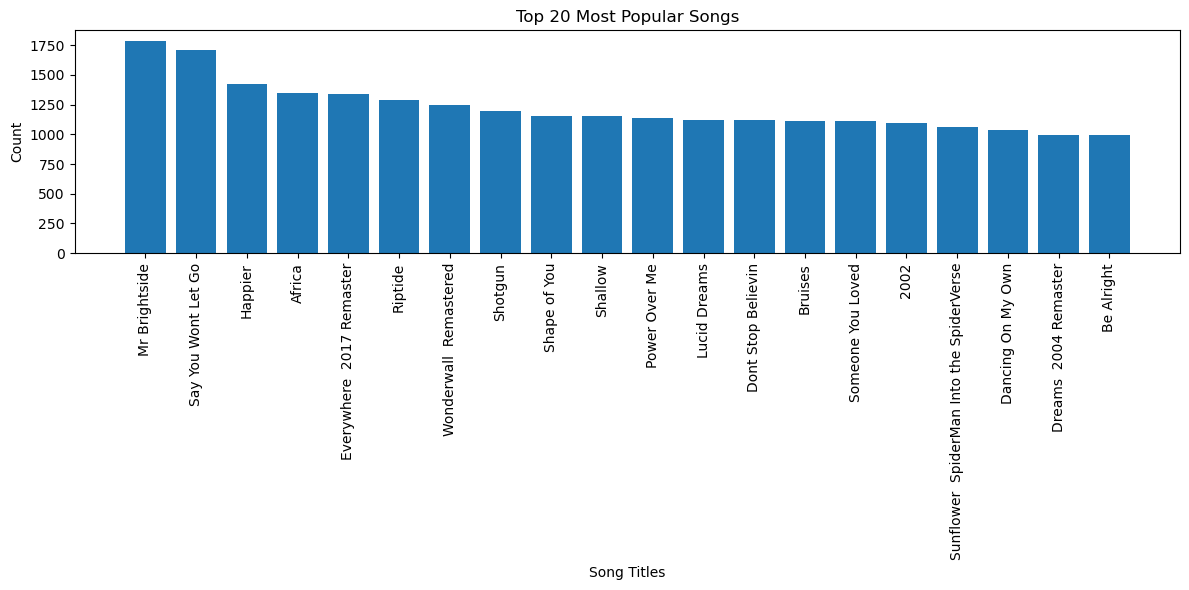

In [23]:
import matplotlib.pyplot as plt
import re # for extracting special characters


# Extract the song titles and their corresponding counts
titles = [row.title for row in popular_songs.collect()]
counts = [row['count'] for row in popular_songs.collect()]

# Remove special characters from song titles
cleaned_titles = [re.sub(r'[^\w\s]', '', title) for title in titles]


# Select the top 20 songs and their counts
top_20_titles = cleaned_titles[:20]
top_20_counts = counts[:20]

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(top_20_titles, top_20_counts)
plt.xlabel('Song Titles')
plt.ylabel('Count')
plt.title('Top 20 Most Popular Songs')
plt.xticks(rotation=90) # tried different rotations 45, 60, but it damages interpretation overlapping labels
plt.tight_layout()

# Show the plot
plt.show()

### Songs ranked as #1 over time


In [24]:
# filter all the #1 songs 
rank_1_songs = charts_irl_top200.filter(charts_irl_top200['rank'] == 1)
rank_1_songs.show()

+--------------------+----+----------+------------+-------+------+-------+
|               title|rank|      date|      artist| region| chart|streams|
+--------------------+----+----------+------------+-------+------+-------+
|Rockabye (feat. S...|   1|2017-01-01|Clean Bandit|Ireland|top200|  24914|
|Rockabye (feat. S...|   1|2017-01-02|Clean Bandit|Ireland|top200|  26654|
|          God's Plan|   1|2018-03-01|       Drake|Ireland|top200|  53355|
|        Shape of You|   1|2017-02-01|  Ed Sheeran|Ireland|top200|  70803|
|Rockabye (feat. S...|   1|2017-01-03|Clean Bandit|Ireland|top200|  29311|
|          God's Plan|   1|2018-03-02|       Drake|Ireland|top200|  51059|
|        Shape of You|   1|2017-02-02|  Ed Sheeran|Ireland|top200|  68387|
|        Shape of You|   1|2017-02-03|  Ed Sheeran|Ireland|top200|  69553|
|          God's Plan|   1|2018-02-01|       Drake|Ireland|top200|  51063|
|Rockabye (feat. S...|   1|2017-01-04|Clean Bandit|Ireland|top200|  30531|
|        Toosie Slide|   

In [25]:
# check how many times each song was in #1 rank



# Group by title and count the occurrences
rank_1_counts = rank_1_songs.groupBy('title').count().orderBy('count', ascending=False)

# Show the resulting DataFrame
rank_1_counts.show()

+--------------------+-----+
|               title|count|
+--------------------+-----+
|        Dance Monkey|  101|
|   Despacito - Remix|   88|
|          God's Plan|   77|
|     drivers license|   69|
|ROCKSTAR (feat. R...|   68|
|           New Rules|   64|
|            Señorita|   63|
|     Blinding Lights|   60|
|        Shape of You|   56|
|One Kiss (with Du...|   55|
|Mood (feat. iann ...|   53|
|STAY (with Justin...|   47|
|       thank u, next|   44|
|          Easy On Me|   43|
|            good 4 u|   43|
|   Someone You Loved|   42|
|Roses - Imanbek R...|   41|
|I Don't Care (wit...|   41|
|All I Want for Ch...|   40|
|            rockstar|   39|
+--------------------+-----+
only showing top 20 rows



### Check correlation between rank and streams of "Africa"


In [26]:
# Calculate correlation between rank and streams
correlation = charts_irl_top200.stat.corr('rank', 'streams')
print(f'Correlation between rank and streams: {correlation}')

Correlation between rank and streams: -0.7062111449911126


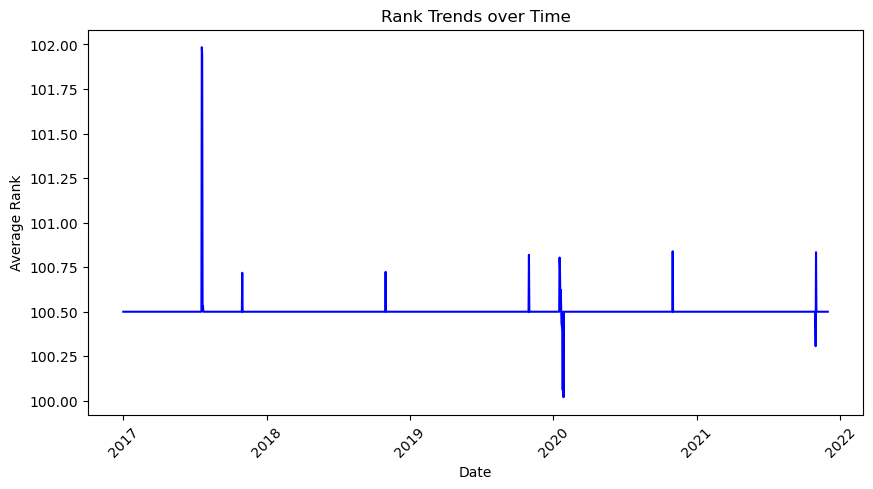

In [27]:
# Import necessary functions
from pyspark.sql.functions import year, month

# Plot rank trends over time
rank_trends = charts_irl_top200.groupBy('date').avg('rank').orderBy('date').toPandas()
plt.figure(figsize=(10, 5))
plt.plot(rank_trends['date'], rank_trends['avg(rank)'], color='blue')
plt.xlabel('Date')
plt.ylabel('Average Rank')
plt.title('Rank Trends over Time')
plt.xticks(rotation=45)
plt.show()


Tried to plot a bar chart to visualize the most popular songs over time. 
however, the code doesnt recognize special charaters for plotting the graph. this means is necessary to perform a cleaning task to remove such special characters from the dataframe and alow matplot to run better.

### Choosing a specific song to see how it behaves over time

based on the 20 most popular song list obtained previously, I selected the song "Africa" by TOTO to look into details how it behaved over the years. choice of song because is only one word for both title and artist features, so there is no need for perfoming text processing to remove special characters, stopwords, etc..


In [28]:
# Filter data for tracking Africa popularity and order it by chronological date
africa_data = charts_irl_top200.filter(charts_irl_top200['title'] == 'Africa').orderBy('date')

#drop 'region', 'charts' 'artist' columns since they repeat each other and are not relevant for the analysis.
africa_data = africa_data.drop('artist', 'region','chart' )
africa_data.show()

+------+----+----------+-------+
| title|rank|      date|streams|
+------+----+----------+-------+
|Africa| 137|2017-01-01|   2526|
|Africa| 186|2017-02-12|   2701|
|Africa| 197|2017-04-08|   3376|
|Africa| 176|2017-04-14|   3438|
|Africa| 196|2017-04-16|   2810|
|Africa| 199|2017-04-22|   3051|
|Africa| 170|2017-04-26|   3302|
|Africa| 197|2017-04-27|   3021|
|Africa| 175|2017-04-29|   3537|
|Africa| 181|2017-04-30|   3060|
|Africa| 195|2017-05-02|   3110|
|Africa| 170|2017-05-03|   3476|
|Africa| 156|2017-05-06|   3699|
|Africa| 155|2017-05-07|   3729|
|Africa| 193|2017-05-09|   3150|
|Africa| 161|2017-05-10|   3579|
|Africa| 197|2017-05-11|   3065|
|Africa| 154|2017-05-13|   3710|
|Africa| 187|2017-05-14|   2985|
|Africa| 191|2017-05-16|   3125|
+------+----+----------+-------+
only showing top 20 rows



In [29]:
africa_data.printSchema()

root
 |-- title: string (nullable = true)
 |-- rank: integer (nullable = true)
 |-- date: date (nullable = true)
 |-- streams: integer (nullable = true)



In [30]:
# No missing data
missing_data = africa_data.agg(*[count(when(isnull(c), c)).alias(c) for c in africa_data.columns])
missing_data.show()

+-----+----+----+-------+
|title|rank|date|streams|
+-----+----+----+-------+
|    0|   0|   0|      0|
+-----+----+----+-------+



In [31]:
# find the minimum and maximum dates
# thisn is important to split the data accordanly. 
date_range = africa_data.agg({'date': 'min'}).union(africa_data.agg({'date': 'max'}))

# Show the result
date_range.show()

+----------+
| min(date)|
+----------+
|2017-01-01|
|2021-11-21|
+----------+



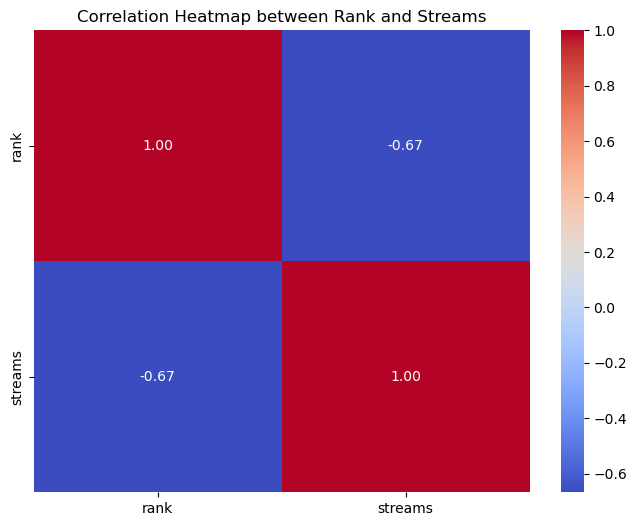

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'africa_data' is your PySpark DataFrame
# Convert it to a Pandas DataFrame
africa_data_pd = africa_data.toPandas()

# Calculate the correlation matrix
correlation_matrix = africa_data_pd[['rank', 'streams', 'date']].corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Rank and Streams')
plt.show()

### Feature engineering

Considering the numceric features for building the model



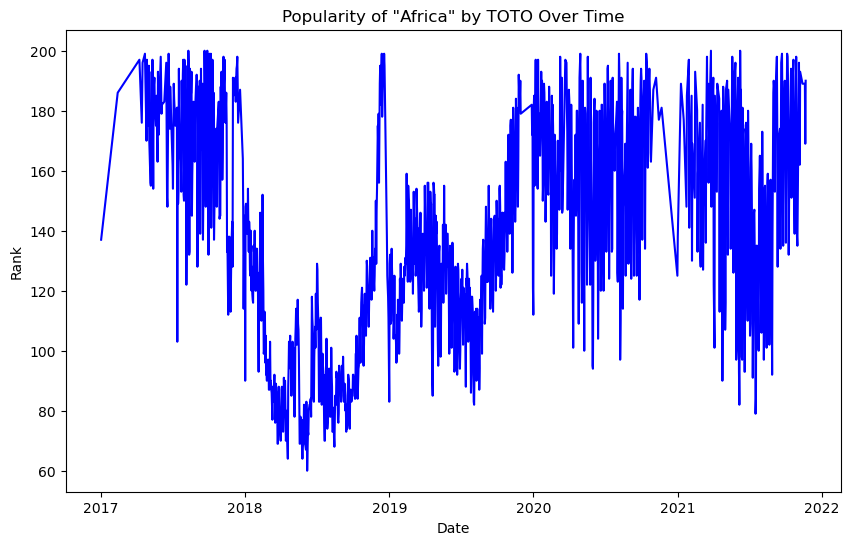

In [33]:
# use this new dataframe to plot a visual representation 

time_series_data = africa_data.select('date', 'rank')

# Convert the DataFrame to Pandas for plotting
time_series_pd = time_series_data.toPandas()

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(time_series_pd['date'], time_series_pd['rank'], color='blue')
plt.xlabel('Date')
plt.ylabel('Rank')
plt.title('Popularity of "Africa" by TOTO Over Time')
plt.show()

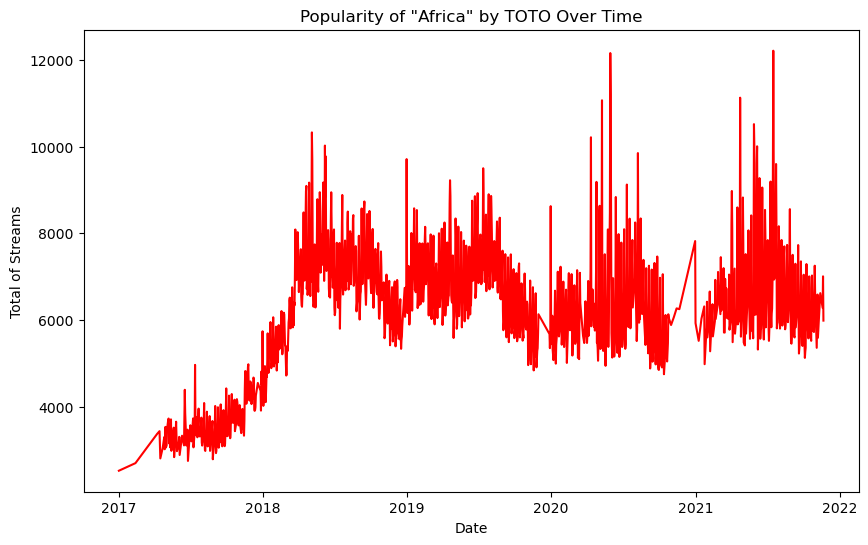

In [34]:
# use this new dataframe to plot a visual representation 

time_series_data = africa_data.select('date', 'streams')

# Convert the DataFrame to Pandas for plotting
time_series_pd = time_series_data.toPandas()

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(time_series_pd['date'], time_series_pd['streams'], color='red')
plt.xlabel('Date')
plt.ylabel('Total of Streams')
plt.title('Popularity of "Africa" by TOTO Over Time')
plt.show()

In [35]:
print(time_series_pd.shape)
time_series_pd.describe()


(1349, 2)


,streams
count,1349.000000
mean,6215.338028
std,1436.409922
min,2526.000000
25%,5551.000000
50%,6302.000000
75%,7057.000000
max,12210.000000


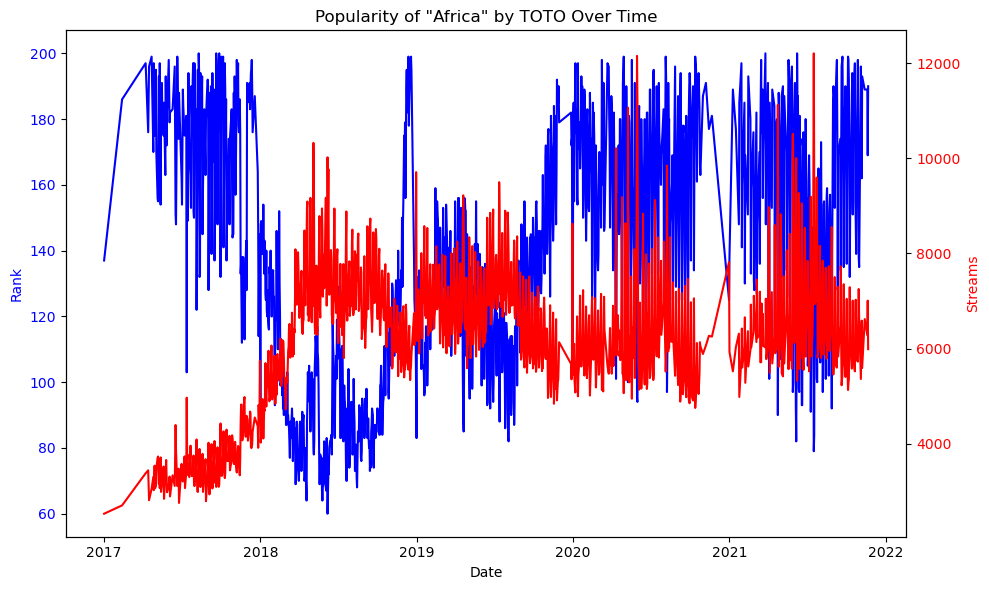

In [36]:
# combining both rank and streams count for Africa,TOTO

time_series_data = africa_data.select('date', 'rank', 'streams')



# Convert the DataFrame to Pandas for plotting
time_series_pd = time_series_data.toPandas()

# Create the figure and the first y-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the rank on the first y-axis
ax1.plot(time_series_pd['date'], time_series_pd['rank'], color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Rank', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title('Popularity of "Africa" by TOTO Over Time')

# Create a second y-axis
ax2 = ax1.twinx()
ax2.plot(time_series_pd['date'], time_series_pd['streams'], color='red')
ax2.set_ylabel('Streams', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Show the plot
plt.tight_layout()
plt.show()

In [37]:
from pyspark.sql.functions import col, lag, avg
from pyspark.sql.window import Window

# Computing the previous rank of the song to enable future rank predictions

window = Window.partitionBy('title').orderBy('date')
previous_rank = africa_data.withColumn('prev_rank', lag('rank', 1).over(window))
previous_rank.show()



+------+----+----------+-------+---------+
| title|rank|      date|streams|prev_rank|
+------+----+----------+-------+---------+
|Africa| 137|2017-01-01|   2526|     null|
|Africa| 186|2017-02-12|   2701|      137|
|Africa| 197|2017-04-08|   3376|      186|
|Africa| 176|2017-04-14|   3438|      197|
|Africa| 196|2017-04-16|   2810|      176|
|Africa| 199|2017-04-22|   3051|      196|
|Africa| 170|2017-04-26|   3302|      199|
|Africa| 197|2017-04-27|   3021|      170|
|Africa| 175|2017-04-29|   3537|      197|
|Africa| 181|2017-04-30|   3060|      175|
|Africa| 195|2017-05-02|   3110|      181|
|Africa| 170|2017-05-03|   3476|      195|
|Africa| 156|2017-05-06|   3699|      170|
|Africa| 155|2017-05-07|   3729|      156|
|Africa| 193|2017-05-09|   3150|      155|
|Africa| 161|2017-05-10|   3579|      193|
|Africa| 197|2017-05-11|   3065|      161|
|Africa| 154|2017-05-13|   3710|      197|
|Africa| 187|2017-05-14|   2985|      154|
|Africa| 191|2017-05-16|   3125|      187|
+------+---

An attempt to plot a boxplot to visualize the distribution of streams and rank. However the configurations for CloudPickleSerializer and its attributes have not been compatible for my Pyspark version. and due to 

In [38]:
time_series_pd.head()
print(time_series_pd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     1349 non-null   object
 1   rank     1349 non-null   int32 
 2   streams  1349 non-null   int32 
dtypes: int32(2), object(1)
memory usage: 21.2+ KB
None


In [39]:
time_series_pd['date'] = pd.to_datetime(time_series_pd['date'])

In [40]:
time_series_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     1349 non-null   datetime64[ns]
 1   rank     1349 non-null   int32         
 2   streams  1349 non-null   int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 21.2 KB


### Converting the dataframe to pandas 

At first, after converting the dataframe to pandas, the 'date' feature was not registered as datetime. However, even after applying pandas function to change the data type, the dataframe did not register the correct format. 
A solution found in literature (Cibilis, 2015) was to create a label for each week that Africa was present in the top200 chart for Ireland (week 1: 01.01.2017 = 1, week 2:12.02.2017 =2, and so on). In this case im using a pyspark function to perform this, which will add a coloum with the new labels, which will then be used for building the model for neural network


In [41]:
# convert africa_data to pandas to apply time series analise
# Convert the DataFrame to Pandas for plotting
africa_data_pd = africa_data.toPandas()
africa_data_pd.head()

,title,rank,date,streams
0,Africa,137,2017-01-01,2526
1,Africa,186,2017-02-12,2701
2,Africa,197,2017-04-08,3376
3,Africa,176,2017-04-14,3438
4,Africa,196,2017-04-16,2810


In [42]:
africa_data_pd.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1349 non-null   object
 1   rank     1349 non-null   int32 
 2   date     1349 non-null   object
 3   streams  1349 non-null   int32 
dtypes: int32(2), object(2)
memory usage: 31.7+ KB


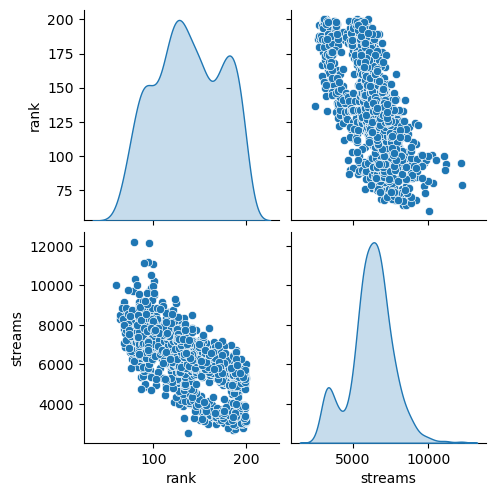

In [43]:
import seaborn as sns
sns.pairplot(data=africa_data_pd, diag_kind='kde')

In [44]:
africa_data_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1349 non-null   object
 1   rank     1349 non-null   int32 
 2   date     1349 non-null   object
 3   streams  1349 non-null   int32 
dtypes: int32(2), object(2)
memory usage: 31.7+ KB


In [45]:
from pyspark.sql.functions import weekofyear

# to create a label for each week, since pandas doesnt recognize when i change the data type
africa_data = africa_data.withColumn('week_number', weekofyear('date'))
africa_data.show()

+------+----+----------+-------+-----------+
| title|rank|      date|streams|week_number|
+------+----+----------+-------+-----------+
|Africa| 137|2017-01-01|   2526|         52|
|Africa| 186|2017-02-12|   2701|          6|
|Africa| 197|2017-04-08|   3376|         14|
|Africa| 176|2017-04-14|   3438|         15|
|Africa| 196|2017-04-16|   2810|         15|
|Africa| 199|2017-04-22|   3051|         16|
|Africa| 170|2017-04-26|   3302|         17|
|Africa| 197|2017-04-27|   3021|         17|
|Africa| 175|2017-04-29|   3537|         17|
|Africa| 181|2017-04-30|   3060|         17|
|Africa| 195|2017-05-02|   3110|         18|
|Africa| 170|2017-05-03|   3476|         18|
|Africa| 156|2017-05-06|   3699|         18|
|Africa| 155|2017-05-07|   3729|         18|
|Africa| 193|2017-05-09|   3150|         19|
|Africa| 161|2017-05-10|   3579|         19|
|Africa| 197|2017-05-11|   3065|         19|
|Africa| 154|2017-05-13|   3710|         19|
|Africa| 187|2017-05-14|   2985|         19|
|Africa| 1

## Splitting the data for building a Neural Network

Starting with an 80:20 split for training and testing. By using portions of the test data (100%, 70%, 50%, etc.), we can see if a smaller test set can cover the variance. Having a smaller portion performing similar to the whole test set proves it’s covered.[https://www.baeldung.com/cs/train-test-datasets-ratio#:~:text=For%20example%2C%20we%20start%20with,test%20set%20proves%20it's%20covered.]


First, to try and use pyspark features, the data was split by filtering data points from 2017-01-01 to 2021-01-01 for training, and the remaining points from 2021 used for testing, as suggested by literature. 
The plots below help to visualize how the data is plot across the dataset, to avoid bias. 


In [46]:
# Filter data for training (2017-2020) and testing (2021)


#80% for training, 20% for testing, 
train_data = africa_data.filter((africa_data['date'] >= '2017-01-01') & (africa_data['date'] < '2021-01-01')) 
test_data = africa_data.filter(africa_data['date'] >= '2021-01-01')

# Show the counts to verify the split
print("Training Data Count: ", train_data.count())
print("Testing Data Count: ", test_data.count())

Training Data Count:  1140
Testing Data Count:  209


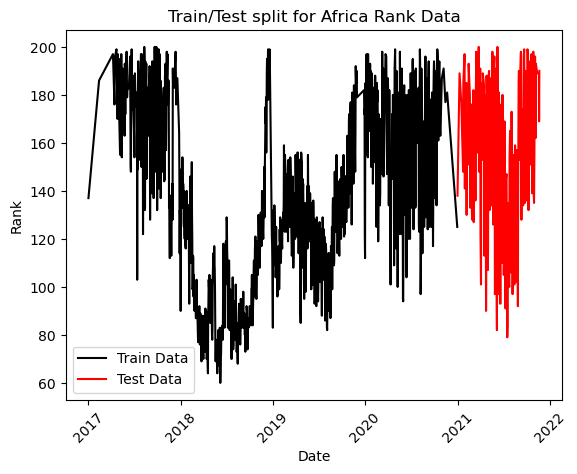

In [47]:


# Splitting Data for Training and Testing - visualisation

# Assuming train_data and test_data are DataFrames with date and streams columns
train_dates = train_data.select('date').toPandas()['date']
train_rank = train_data.select('rank').toPandas()['rank']

test_dates = test_data.select('date').toPandas()['date']
test_rank = test_data.select('rank').toPandas()['rank']

# Plotting
plt.plot(train_dates, train_rank, color='black', label='Train Data')
plt.plot(test_dates, test_rank, color='red', label='Test Data')
plt.ylabel('Rank')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for Africa Rank Data")
plt.legend()
plt.show()

In [48]:
 from sklearn.metrics import mean_squared_error

In [49]:
train_data.head()

Row(title='Africa', rank=137, date=datetime.date(2017, 1, 1), streams=2526, week_number=52)

In [50]:
# using africa_data_pd as a Pandas DataFrame, convert to appropriate datatype
africa_data_pd['date'] = pd.to_datetime(africa_data_pd['date'], format='%Y-%m-%d')

# Filter data for training (2017-2020) and testing (2021)
train_data = africa_data_pd[(africa_data_pd['date'] >= '2017-01-01') & (africa_data_pd['date'] < '2021-01-01')]
test_data = africa_data_pd[africa_data_pd['date'] >= '2021-01-01']

# Show the counts to verify the split
print("Training Data Count: ", len(train_data))
print("Testing Data Count: ", len(test_data))

Training Data Count:  1140
Testing Data Count:  209


#### attempt to split data using africa_data_pd as a baseline 

First attempt was not possible to have all dates in the right format, and as mentioned in class notes, time series analysis require the timestand to be as an index. So we set the date as an index once its coverted to datetime type and proceed with the splitting between train and test samples. 

In [51]:
# setting the dates as index
africa_data_pd['date'] = pd.to_datetime(africa_data_pd['date'])

africa_data_pd.set_index('date', inplace=True)


In [52]:
print(africa_data_pd.info())
display(africa_data_pd)
display(africa_data_pd.describe())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1349 entries, 2017-01-01 to 2021-11-21
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1349 non-null   object
 1   rank     1349 non-null   int32 
 2   streams  1349 non-null   int32 
dtypes: int32(2), object(1)
memory usage: 31.6+ KB
None


,title,rank,streams
date,,,
2017-01-01,Africa,137,2526
2017-02-12,Africa,186,2701
2017-04-08,Africa,197,3376
2017-04-14,Africa,176,3438
2017-04-16,Africa,196,2810
...,...,...,...
2021-11-07,Africa,193,5591
2021-11-13,Africa,189,6620
2021-11-19,Africa,189,6281


,rank,streams
count,1349.000000,1349.000000
mean,137.618977,6215.338028
std,35.900168,1436.409922
min,60.000000,2526.000000
25%,110.000000,5551.000000
50%,136.000000,6302.000000
75%,169.000000,7057.000000
max,200.000000,12210.000000


## Distribution of data

This section will display the plots created to understand how the data is distributed and identify possible outliers. The first boxplot was made with the basic data and we can see the different scales affect interpreting the results, while the rank varies between 0 and 200, the streams are registered in the thousands scales.
Different scales of the data features affect the modeling of a dataset adversely.

It leads to a biased outcome of predictions in terms of misclassification error and accuracy rates. So, it is necessary to Scale the data prior to modeling. This is when standardization comes into picture.

Standardization is a scaling technique wherein it makes the data scale-free by converting the statistical distribution of the data where uses the mean = 0 (zero) and standard deviation = 1 (Mulani, 2022)



### Box plot of "Africa" by TOTO rank position and total streams from 2017 to 2021


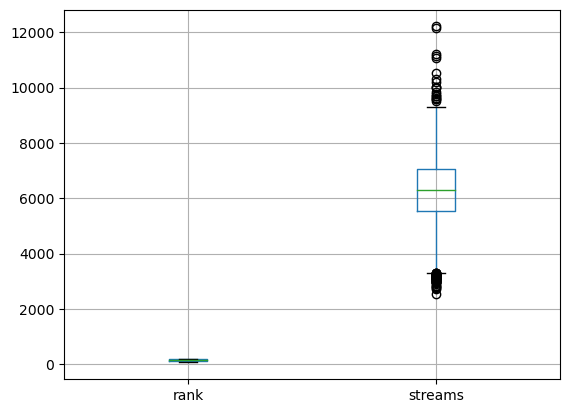

In [53]:
# boxplot before using scaler
africa_data_pd.boxplot(column=['rank', 'streams'])
plt.show()

### Using StandardScaler() for "Africa" dataset


In [54]:
# Creating a separate (copy) DataFrame for scaling.
africa_scaled = africa_data_pd.copy()


from sklearn.preprocessing import StandardScaler # standardize the data


# Standardize the variables.
scaler = StandardScaler() 
africa_scaled[['rank','streams']] = scaler.fit_transform(
africa_scaled[['rank','streams']])


#check values
print(africa_scaled.head())

             title      rank   streams
date                                  
2017-01-01  Africa -0.017248 -2.569396
2017-02-12  Africa  1.348154 -2.447520
2017-04-08  Africa  1.654673 -1.977424
2017-04-14  Africa  1.069501 -1.934245
2017-04-16  Africa  1.626808 -2.371608


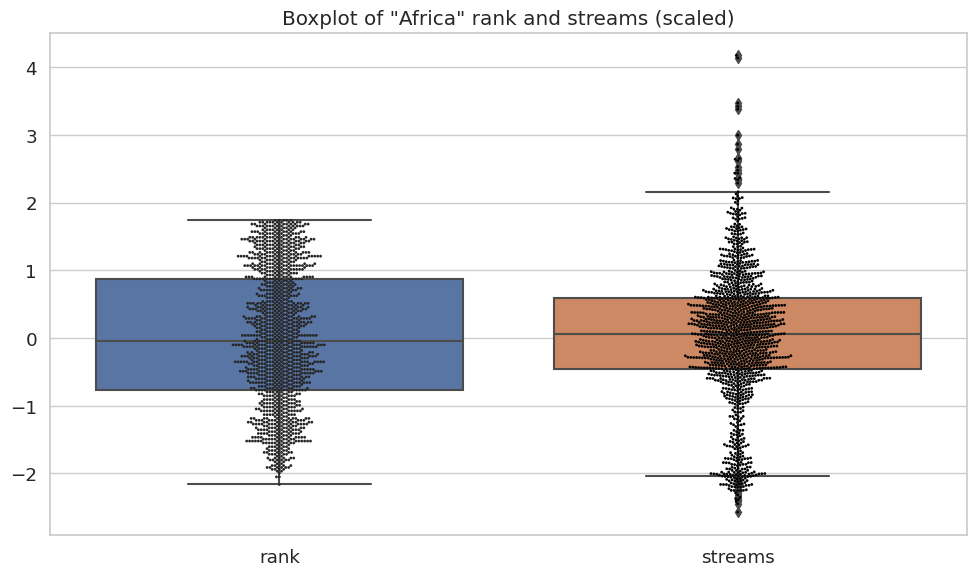

In [55]:
#create a boxplot with all the values to check difference in outliers 

# Creates the figure with the boxplots. 
plt.figure(figsize=(10,6)) # Setting the figure size to display all labels clearly at x-axis

 # Addind a whitegrid background + adjust font scale.
sns.set(style="whitegrid", font_scale=1.2)


# Create the boxplot
ax = sns.boxplot(data=africa_scaled)

# Add title to the figure.
ax.set_title('Boxplot of "Africa" rank and streams (scaled)') 

# Add each data point with swarmplot to better identify values
# Each data point is maked in color black for contrast
sns.swarmplot(data=africa_scaled, color='black', size=2)

plt.tight_layout() # Adjusts the layout.
plt.show() # Shows the plot.

### Checking correlation between rank and streams of "Africa"

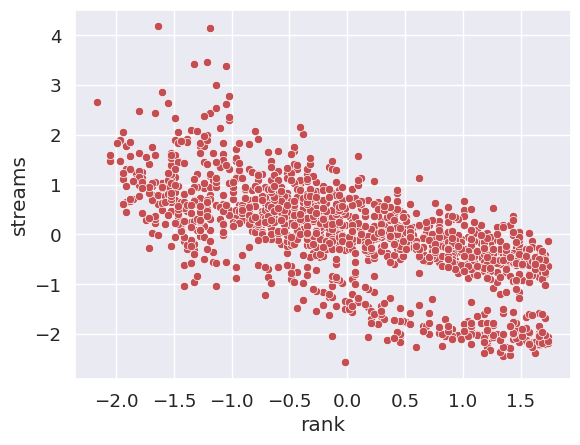

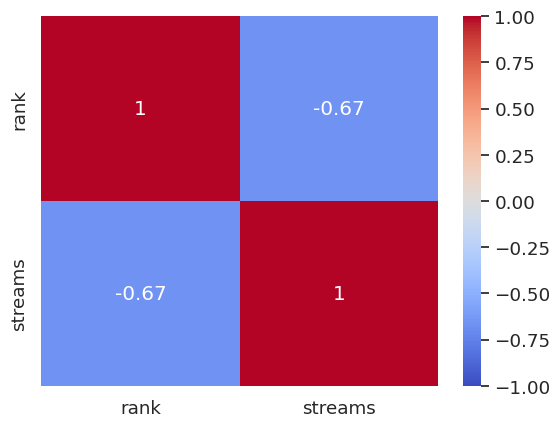

In [56]:
sns.set_style('darkgrid')

# create a scatterplot to show the relationship between the rank and streams of Africa
sns.scatterplot(x='rank', y='streams', data=africa_scaled, color='r')
plt.show()

# create a heatmap to show the correlation between the variables
sns.heatmap(africa_data_pd.corr(), annot=True, vmin=-1.0, vmax=1.0, cmap='coolwarm')
plt.show()

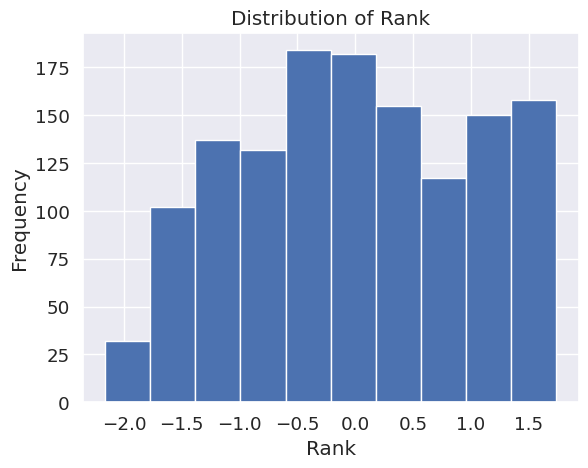

In [57]:
africa_scaled['rank'].hist()
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Distribution of Rank')
plt.show()

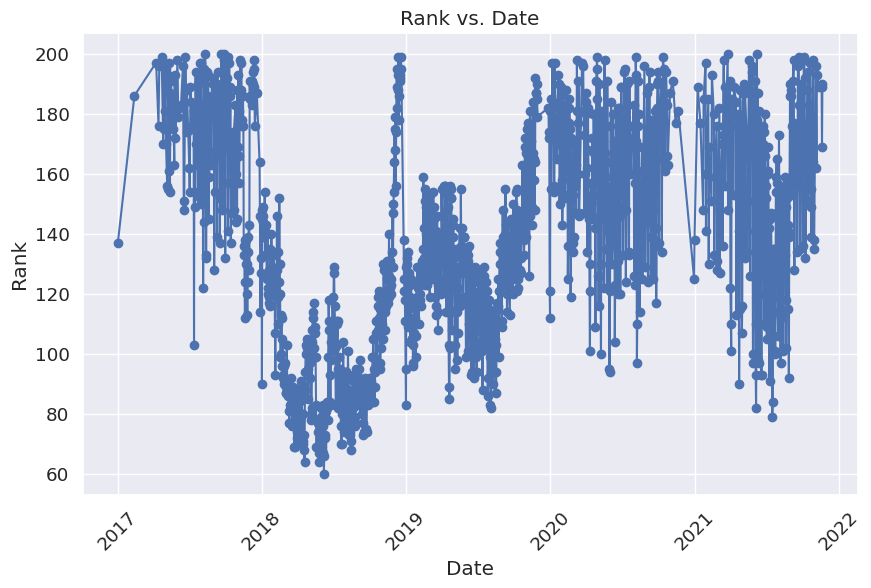

In [58]:
# see how rank changes over time
plt.figure(figsize=(10, 6))
plt.plot(africa_data_pd.index, africa_data_pd['rank'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Rank')
plt.title('Rank vs. Date')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

#### Performing a Shapiro-Wilk test to verify normality in data's distribution (using scaled dataframe)

### Rank feature

In [67]:

# Perform the Shapiro-Wilk test for rank feature
stat, p_value = stats.shapiro(africa_scaled['rank'])

# Print the results
print(f"Test Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value > alpha:
    print("The data looks normally distributed (fail to reject H0)")
else:
    print("The data does not look normally distributed (reject H0)")
    
    


Test Statistic: 0.9667588472366333
P-value: 4.7971770524751404e-17
The data does not look normally distributed (reject H0)


### shapiro test for streams feature

In [68]:
# Perform the Shapiro-Wilk test for rank feature
stat, p_value = stats.shapiro(africa_scaled['streams'])

# Print the results
print(f"Test Statistic: {stat}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05
if p_value > alpha:
    print("The data looks normally distributed (fail to reject H0)")
else:
    print("The data does not look normally distributed (reject H0)")
    

Test Statistic: 0.9736027121543884
P-value: 5.295129060971324e-15
The data does not look normally distributed (reject H0)


## Using scaled data to split between train/test

My initial idea was to use the scaled data in its totality to then split train and test sets. however, after some more research, a similar query in StackExchange gave insights on using the Standard Scaler directly to the training set only, to avoid any information of the original dsitribution of the test set to leak into the model. 

(https://datascience.stackexchange.com/questions/38395/standardscaler-before-or-after-splitting-data-which-is-better)


In [ ]:


# Select features for independendt and dependent varibles
#X = africa_scaled[['rank', 'streams']]  # Features
#y = africa_scaled['rank']  # Target variable

# Splitting the data into 80% training and 20% testing
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 20% for testing, 80% training 


## Splitting the train/test sets while applying a StandardScaler for training test:


In [69]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features for independent and dependent variables
X = africa_data_pd[['rank', 'streams']]  # Features
y = africa_data_pd['rank']  # Target variable

# Splitting the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Autoregressive Moving Average (ARMA)

code adapted from class notes A Guide to Time Series Forecasting in Python


In [70]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# define the model. 
# y (independednt variable) selected on line above

# To define an ARMA model with the SARIMAX class, we pass in the order parameters of (1, 0 ,1):
ARMAmodel = SARIMAX(y, order = (1, 0, 1))

/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/lib/python3/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [72]:
np.asarray(train_data)

array([['Africa', 137, Timestamp('2017-01-01 00:00:00'), 2526],
       ['Africa', 186, Timestamp('2017-02-12 00:00:00'), 2701],
       ['Africa', 197, Timestamp('2017-04-08 00:00:00'), 3376],
       ...,
       ['Africa', 177, Timestamp('2020-11-14 00:00:00'), 6269],
       ['Africa', 181, Timestamp('2020-11-21 00:00:00'), 6251],
       ['Africa', 125, Timestamp('2020-12-31 00:00:00'), 7821]],
      dtype=object)

### Attempt to build a Neural Network 


In [73]:
#!pip install tensorflow


In [74]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming 'africa_data' is a Pandas DataFrame
# Split data into features (X) and target (y)
X = africa_data[['week_number', 'streams']].values
y = africa_data['rank'].values

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(2,)),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Train the model
model.fit(X, y, epochs=10, batch_size=32, validation_split=0.2)

ModuleNotFoundError: No module named 'tensorflow'

In [76]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

ModuleNotFoundError: No module named 'keras'

ModuleNotFoundError: No module named 'keras'